MS BigData 2015/2016<br>
Catherine Verdier
# Devoir 1 : Intervalles de confiance et méthodes gloutonnes



In [26]:
#
# Importer les librairies nécessaires
#
import numpy as np
import matplotlib.pyplot as plt  # for plots
from sklearn import linear_model
from matplotlib import rc
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Math, Latex
import statsmodels.api as sm
from scipy.stats import t
from numpy.linalg import inv
from sklearn import utils


In [27]:
#
# Initialisation plots, latex, ...
#
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'text.fontsize': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
mc3my_brown = (0.64, 0.16, 0.16)
purple = (148. / 255, 0, 211. / 255)

##############################################################################
# Scatter plot
#sns.set_style("white")


In [28]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Exercice 1 : Régression multivariée
## Question 1
On cherche à trouver un estimateur linéaire de la concentration en ozone à partir des variables suivantes :
<ul>
    <li>le rayonnement solaire</li>
    <li>la force du vent</li>
    <li>la température</li>
    <li>la date de la mesure (correspondant à deux paramètres JJ et MM où JJ est le numéro du jour dans le<br>
    mois et MM les numéro du mois dans l'année)</li> 
</ul>
<br>
On cherchera cet estimateur en utilisant la méthode des moindres carrés multi-dimentionnels:

In [29]:
display(Math(r'$On~appelle~{y}_i,~la~valeur~de~la~concentration~en~ozone~pour~la~i^{ème}~observation$'))
display(Math(r'$On~appelle~{x}_{ij},~le~paramètre~de~la~colonne~j~de~la~i^{ème}~observation$'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

On supposera qu'on dispose de p variales explicatives, i.e. j varie de 1 à p<br>
On supposera qu'on dispose de n observations, i.e. i varie de 1 à n<br>
L'estimateur des moindres carrés s'exprime alors par:

In [30]:
display(Math(r'$y_i = {\theta}_0^{*} + \sum_{j=1}^{p} {\theta}_j^{*}x_{ij} + {\epsilon}_i$'))
print("avec:")
display(Math(r'${\epsilon}_i = {\cal{N}}(0,{\sigma}^2)~~~~~~~~~~ \forall i = 1,...,n$'))


<IPython.core.display.Math object>

avec:


<IPython.core.display.Math object>

## Question 2
Récupération du jeu de données airquality

In [31]:
aq_data = sm.datasets.get_rdataset('airquality').data
aq_data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41,190,7.4,67,5,1
1,36,118,8.0,72,5,2
2,12,149,12.6,74,5,3
3,18,313,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


In [32]:
print("Nombre d'observations :"+str(len(aq_data)))

Nombre d'observations :153


## Question 3
Elimination des lignes contenant des valeurs non définies

In [33]:
aq_data = aq_data.dropna()
aq_data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41,190,7.4,67,5,1
1,36,118,8.0,72,5,2
2,12,149,12.6,74,5,3
3,18,313,11.5,62,5,4
6,23,299,8.6,65,5,7


In [34]:
print("Nombre d'observations :"+str(len(aq_data)))

Nombre d'observations :111


## Question 4

In [35]:
#
# Définir notre matrice X et notre vecteur y définis à la question 1
#
X = aq_data[['Solar.R', 'Wind', 'Temp', 'Month', 'Day']]
y = aq_data['Ozone']
#
# Centrer/réduire les variables explicatives
#
X_mean = np.mean(X)
X_std = np.std(X)
Xcr = (X - X_mean)/X_std
Xcr.head()
#
# Calcul des paramètres de l'estimateur des moindres carrés avec scikit learn
#
skl_aq_data_ozone = linear_model.LinearRegression()
skl_aq_data_ozone.fit(Xcr, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Question 5
Paramètres du modèle linéaire trouvés avec scikit learn

In [36]:
theta0 = np.array([skl_aq_data_ozone.intercept_])
theta = np.concatenate((theta0,skl_aq_data_ozone.coef_),axis=0)
print theta

[ 42.0990991    4.56193076 -11.75277084  17.98521995  -4.45895297
   2.37393859]


In [37]:
display(Math(r'$\widehat\theta = \begin{bmatrix}'+r'{0}'.format(theta[0])+r'\\{0}'.format(theta[1])+r'\\{0}'.format(theta[2])+r'\\{0}'.format(theta[3])+r'\\{0}'.format(theta[4])+r'\\{0}'.format(theta[5])+r'\end{bmatrix}$'))

<IPython.core.display.Math object>

Formule théorique permettant d'obtenir un estimateur sans biais de la variance du bruit:

In [38]:
display(Math(r'$Var({\epsilon}_i)\approx{\widehat\sigma}^2 = \frac{{\left \| y - X{\widehat\theta} \right \|}^2_2}{n-rg(X)}~~~~~~~~ \forall i = 1,...,n$'))

<IPython.core.display.Math object>

Pour appliquer cette formule, on doit transformer la matrice X et lui ajouter une colonne de 1 pour prendre en compte le vecteur intercept $\widehat\theta_0$<br>
X est ici une matrice $n$x$(p+1)$ avec $x_{i0}$ = 1 pour tout i variant de 1 à n

In [39]:
#
# Calcul de l'estimateur de la variance du bruit
#

theta = np.array(theta,float)
# On peut appliquer la formule matricielle avec une matrice X_plus ([1_n]+X)
# Dans le cas considéré, on peut se permettre de calculer explicitement cette
# matrice car le volume des données est faible
# Si on opère sur une matrice à grande dimension, on se contentera d'ajouter 1
# au rang de la matrice initiale
X_plus = Xcr.copy()
if not 'Cst' in X_plus:
    X_plus.insert(0,'Cst',np.ones(X_plus.shape[0]))
sigma2 = (((y-np.dot(X_plus,theta.T))**2).sum())/(len(aq_data)-np.linalg.matrix_rank(X_plus))
display(Math(r'${\widehat\sigma}^2 ~~= '+r'{0}$'.format(sigma2)))

# On peut aussi calculer cette variance avec la fonction predict de sklearn
y_hat = skl_aq_data_ozone.predict(Xcr)
sigma2predict = ((((y-y_hat)**2).sum()))/(len(aq_data)-np.linalg.matrix_rank(X_plus))
display(Math(r'${\widehat\sigma}^2_{skl} = '+r'{0}$'.format(sigma2predict)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Question 6
Pour cette question, on admettra la Proposition 1 de l'énoncé :

In [40]:
display(Math(r'$\forall u \in {\mathbb{R}}^n~~~~ \frac{u^T(\widehat\theta-\theta^{*})}{\widehat\sigma\sqrt{u^T{(X^TX)}^{-1}u}}$'))

<IPython.core.display.Math object>

Cette proposition reste vraie si on l'applique à une famille de p+1 vecteurs $u_j$ orthonormés.<br>
Ce qui revient à dire que :

In [41]:
display(Math(r'$\frac{({\widehat\theta}_j-\theta^{*}_j)}{\widehat\sigma\sqrt{[{(X^TX)}^{-1}]_{jj}}} ~~~~~~suit~une~loi~de~Student~à~n-p-1~degrés~de~liberté~pour~j=1,...,p+1$'))

<IPython.core.display.Math object>

In [42]:
# Calcul d'un intervalle de confiance à 99% pour un degré de liberté n-p-1
n = Xcr.shape[0]
p = Xcr.shape[1]
student_interval = t.interval(0.99,n-p-1)
student_bound = student_interval[1]
# Dans le cas considéré, on peut calculer et inverser la matrice de Gram puisque p est petit devant n
# La matrice à inverser est de dimensions (6x6), ce qui est acceptable d'un point de vue computationnel
XTX = np.dot(X_plus.transpose(),X_plus)
XTX_1 = inv(XTX)
# Ecart-type pour les résidus
sigma_hat = np.sqrt(sigma2)
# Création des bornes inférieures des p+1 intervalles de confiance
# Note : l'utilisation de la diagonale est une idée de Florian, pour qui la parcimonie
#        est toujours un souci
student_inf_bound = theta-student_bound*sigma_hat*np.sqrt(np.diag(XTX_1))
# Création des bornes supérieures des p+1 intervalles de confiance
student_sup_bound = theta+student_bound*sigma_hat*np.sqrt(np.diag(XTX_1))
# Enregistrement des intervalles de confiance dans un DataFrame panda
theta_intervalles_99 = pd.DataFrame(index=X_plus.columns)
theta_intervalles_99['inf'] = student_inf_bound
theta_intervalles_99['sup'] = student_sup_bound
print
print("Intervalles de confiance à 99% par paramètre du modèle:")
theta_intervalles_99.head(6)


Intervalles de confiance à 99% par paramètre du modèle:


,inf,sup
Cst,36.905168,47.293030
Solar.R,-1.012992,10.136853
Wind,-17.741167,-5.764375
Temp,11.168540,24.801900
Month,-10.282812,1.364907
Day,-2.848751,7.596628


## Question 7

On constate que les intervalles de confiance des variables Month et Day incluent la valeur 0.<br>
Il est donc impossible d'assurer avec certitude que l'une ou l'autre de ces variables aient une valeur explicative.

## Question 8

In [67]:
#
# Creation d'une nouvelle entrée
#
X_new = np.array([197., 10., 70., 3., 1.])
# centrer/réduire X_new avec moyenne et écart-type du dataset de fitting
X_new = (X_new-X_mean)/X_std
# Calcul de l'image de X_new 
y_new_hat = skl_aq_data_ozone.predict(X_new)
print("Avec les entrées suivantes:")
print(X_new)
print
print("Notre modèle prédit la concentration en ozone :")
print(y_new_hat)

Avec les entrées suivantes:
Solar.R    0.134429
Wind       0.017043
Temp      -0.821423
Month     -2.874467
Day       -1.724290
dtype: float64

Notre modèle prédit la concentration en ozone :
[ 36.46233787]


# Exercice 2 : Bootstrap

## Question 1

In [44]:
"""
    Définition des variables et fonctions utiles pour les différentes
    phases de Bootstrap à venir...
"""
#
# Noms des observations des modèles bootstrap
#
obs_names = ['Solar.R', 'Wind', 'Temp', 'Month', 'Day']
#
# Nom de l'explication
#
exp_name = 'Ozone'

#
# Création des matrices X et du vecteur y à partir d'un échantillon
# donné sous la forme d'un DataFrame panda
#
def getXy(sample):
    X = sample[obs_names]
    y = sample[exp_name]
    return X,y

#
# Calcul des tableaux de moyennes empiriques et écart-types empiriques
# sur les colonnes du Dataframe des observations
#
def getMeansAndStds(X):
    X_mean = np.mean(X)
    X_std = np.std(X)
    return X_mean, X_std

#
# Centrer/réduire les variables explicatives
#
def standardize(X):
    return (X - X.mean())/X.std()
    
#
# Faire une régression linéaire avec sklearn sur un sample donné
#
def linear_r(Xcr, y):
    skl = linear_model.LinearRegression()
    skl.fit(Xcr, y)
    return skl

#
# Régression linéraire sur un échantillon Bootstrap
# retourne les paramètres du modèle obtenus par une régression linéaire
#
def linear_r_bootstrap(mX):
    bootstrap = utils.resample(mX, replace=True)
    bX, by = getXy(bootstrap)
    bX = standardize(bX)
    skl = linear_r(bX, by)
    theta0b = np.array([skl.intercept_])
    thetab = np.concatenate((theta0b,skl.coef_),axis=0)
    return thetab


In [72]:
#
# On crée B Bootstrap sur lesquels on opère une régression linéaire
# On stocke les paramètres obtenus dans un DataFrame
#
B = 10000
theta_bootstrap = pd.DataFrame(columns=['Cste']+obs_names)

for i in range(0,B):
    theta = linear_r_bootstrap(aq_data)
    theta_bootstrap.loc[i] = theta
    if i % 1000 == 0 and i != 0:
        print str(i)+" linear regressions fitted with bootstrap samples ..."

print(str(len(theta_bootstrap))+" linear regressions fitted with bootstrap samples")
print("Done.")
print

#
# Check if parameters seem to be compliant with results found in the Exercice 1
#
print("Check if parameters seem to be compliant with results found in the Exercice 1")
theta_bootstrap.head()

1000 linear regressions fitted with bootstrap samples ...
2000 linear regressions fitted with bootstrap samples ...
3000 linear regressions fitted with bootstrap samples ...
4000 linear regressions fitted with bootstrap samples ...
5000 linear regressions fitted with bootstrap samples ...
6000 linear regressions fitted with bootstrap samples ...
7000 linear regressions fitted with bootstrap samples ...
8000 linear regressions fitted with bootstrap samples ...
9000 linear regressions fitted with bootstrap samples ...
10000 linear regressions fitted with bootstrap samples ...
11000 linear regressions fitted with bootstrap samples ...
12000 linear regressions fitted with bootstrap samples ...
13000 linear regressions fitted with bootstrap samples ...
14000 linear regressions fitted with bootstrap samples ...
15000 linear regressions fitted with bootstrap samples ...
16000 linear regressions fitted with bootstrap samples ...
17000 linear regressions fitted with bootstrap samples ...
18000 

,Cste,Solar.R,Wind,Temp,Month,Day
0,44.603604,6.324634,-16.668678,14.973883,-4.940565,4.726356
1,44.738739,7.164790,-12.638599,15.347204,-0.362094,6.872193
2,39.729730,4.266898,-9.445586,18.827096,-3.921161,5.357027
3,45.558559,6.623295,-15.025142,16.311020,-0.466217,0.033679
4,44.297297,6.924530,-14.604881,16.740351,-5.911019,1.722771


In [73]:
print("==================")
print("Moyenne des thetas")
print("==================")
print(theta_bootstrap.mean())
print("=========================================")
print("Différence avec le modèle de l'exercice 1")
print("=========================================")
print(theta_bootstrap.mean()-theta)
print("==================")
print("Médiane des thetas")
print("==================")
print(theta_bootstrap.median())
print("=========================================")
print("Différence avec le modèle de l'exercice 1")
print("=========================================")
print(theta_bootstrap.median()-theta)

Moyenne des thetas
Cste       42.136861
Solar.R     4.575992
Wind      -11.838842
Temp       17.989326
Month      -4.444072
Day         2.401027
dtype: float64
Différence avec le modèle de l'exercice 1
Cste      -4.241517
Solar.R   -2.240150
Wind       3.409955
Temp       3.924154
Month     -3.202432
Day       -2.597028
dtype: float64
Médiane des thetas
Cste       42.099099
Solar.R     4.543558
Wind      -11.676450
Temp       18.006979
Month      -4.439308
Day         2.413543
dtype: float64
Différence avec le modèle de l'exercice 1
Cste      -4.279279
Solar.R   -2.272584
Wind       3.572348
Temp       3.941808
Month     -3.197668
Day       -2.584512
dtype: float64


## Question 2

Avec l'échantillon de modèles linéaires possibles obtenus, nous allons calculer un intervalle de confiance de niveau 99% pour chaque paramètre de régression à partir des quantiles empiriques de chaque paramètre.<br>

In [74]:
#
# Trouver les bornes d'un intervalle de confiance à partir de la fonction percentile de numpy
# sur un échantillon
#
# Paramètres :
#     X          : échantillon considéré sous la forme d'un DataFrame panda
#     column     : nom de la colonne sur laquelle on va opérer
#     b_min      : percentile min
#     b_max      : percentile max

def ic_emp_q(X, column, b_min, b_max):
    # trier les données selon la colonne
    X_ic = X.sort(columns = column)
    # retrouver les percentiles correspondant
    p_min = np.percentile(X_ic[column], b_min)
    p_max = np.percentile(X_ic[column], b_max)
    return p_min, p_max

#
# On doit appliquer la fonction définie ci-dessus à chaque colonne de notre DataFrame
# obtenu par Bootstrap
# On rangera les résultats obtenus dans un DataFrame
#

theta_ic_99_v2 = pd.DataFrame(index=['Cste']+obs_names, columns=['inf', 'sup'])

for column in ['Cste']+obs_names:
    p_min, p_max = ic_emp_q(theta_bootstrap, column, 0.5, 99.5)
    theta_ic_99_v2['inf'][column] = p_min
    theta_ic_99_v2['sup'][column] = p_max

#
# Affichage du résultat
#
theta_ic_99_v2.head(6)


,inf,sup
Cste,34.45941,50.49572
Solar.R,0.05349242,9.513734
Wind,-20.2577,-4.972818
Temp,11.7353,23.9301
Month,-9.550174,0.5764986
Day,-3.096255,7.808406


In [118]:
#
# Vérification des résultats obtenus en utilisant DataFrame.quantile de panda
#
qt = theta_bootstrap.quantile([0.005, 0.995])

qt.head()

,Cste,Solar.R,Wind,Temp,Month,Day
0.005,34.459414,0.053492,-20.257700,11.735298,-9.550174,-3.096255
0.995,50.495721,9.513734,-4.972818,23.930099,0.576499,7.808406


## Question 3

,B,inf,sup,median
0,1,-16.668678,-16.668678,-16.668678
1,501,-19.668582,-5.418244,-11.477602
2,1001,-20.041262,-5.416586,-11.669362
3,1501,-19.875891,-5.402233,-11.708862
4,2001,-20.041262,-5.387881,-11.631689


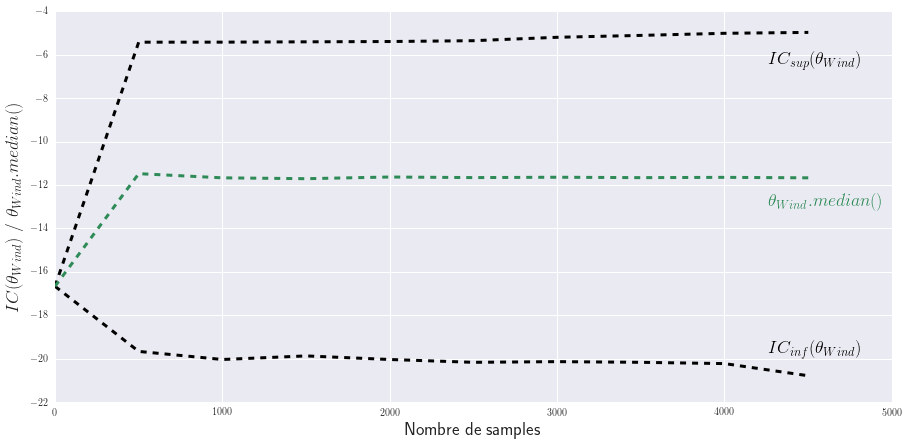

In [106]:
from matplotlib import colors
#
# Stocker les données à afficher dans un DataFrame
#
df_wind = pd.DataFrame(columns=['B', 'inf', 'sup', 'median'])
Bstep = 500
Blast = Bstep
for idx in range(1,5001,Bstep):
    Blast = idx+Bstep
    # prendre les poids des modèles pour la variable 'Wind' jusqu'à Blast
    X_Wind = theta_bootstrap['Wind'][0:idx]
    # Calculer l'intervalle de confiance pour ce dataset
    qtWind = X_Wind.quantile([0.005, 0.995])
    df_wind.loc[len(df_wind)] = {'B':idx, 'inf':qtWind[0.005], 'sup':qtWind[0.995], 'median':X_Wind.median()}
    
fig, ax = plt.subplots(figsize=(15, 7))
plt.subplots_adjust(hspace=0.3)
ax.plot(df_wind['B'], df_wind['inf'], "r--", color='black', linewidth=3)
ax.plot(df_wind['B'], df_wind['sup'], "r--", color='black', linewidth=3)
ax.plot(df_wind['B'], df_wind['median'], "r--", color='seagreen', linewidth=3)
plt.xlabel('Nombre de samples', fontsize=18)
plt.ylabel(r'$IC({\theta}_{Wind})~/~{\theta}_{Wind}.median()$', fontsize=18)
plt.annotate(r'$IC_{inf}(\theta_{Wind})$',
             xy=(4200, df_wind['inf'].min()-0.5), xycoords='data', xytext=(+10, +30),
             textcoords='offset points', fontsize=18, color ='black')
plt.annotate(r'$IC_{sup}(\theta_{Wind})$',
             xy=(4200, df_wind['sup'].max()-3), xycoords='data', xytext=(+10, +30),
             textcoords='offset points', fontsize=18, color ='black')
plt.annotate(r'$\theta_{Wind}.median()$',
             xy=(4200, df_wind['median'].max()-3), xycoords='data', xytext=(+10, +30),
             textcoords='offset points', fontsize=18, color ='seagreen')

df_wind.head()

## Question 4

Sur la régression de 'Ozone' sur 'Wind' par mois calculée et représentée graphiquement avec seaborn.lmplot,
on constate une régression atypique sur le mois de Juin (6) où le coefficient directeur de la régression est
positif alors que pour toutes les autres régression, on a obtenu un coefficient directeur négatif.

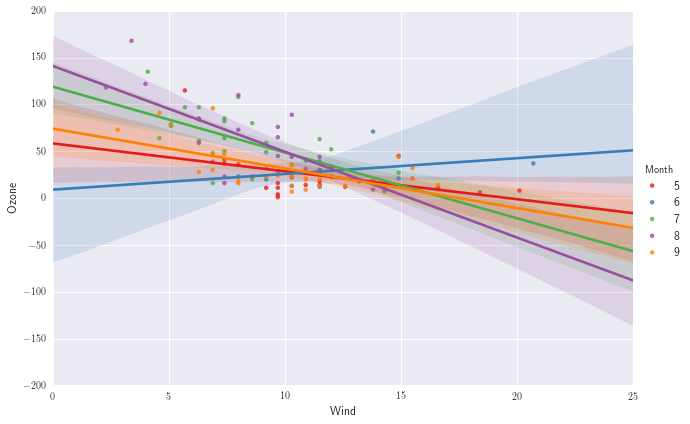

In [113]:
sns.lmplot(x="Wind", y="Ozone", hue="Month", data=aq_data, palette="Set1", legend=True, size=6, aspect=1.5);

# Exercice 3 : algorithmes glouton (greedy)

## Question 1 : implémentation de la fonction stpforward

In [119]:
#
# Génération de la matrice X_S
# Paramètres :
#    - X      : matrice sous la forme d'un DataFrame panda
#    - S      : une liste d'indice de colonnes à sélectionner dans X
# Retour :
#    Un DataFrame composé des colonnes dont les indices sont présents dans S
#
def getX_S(X, S):
    columns_X = []
    for idx in S:
        columns_X.append(X[X.columns[idx]])
    return pd.concat(columns_X)

#
# Régression linéraire de y sur X
# retourne les paramètres du modèle obtenus par une régression linéaire
# et le vecteur résidu (y-y_hat)
#
def least_square(mX, my):
    bX = standardize(mX)
    skl = linear_r(bX, my)
    theta0b = np.array([skl.intercept_])
    thetab = np.concatenate((theta0b,skl.coef_),axis=0)
    y_hat = skl.predict(bX)
    return thetab, my-y_hat

#
# Réajuster theta avec les 0 manquants pour les paramètres exclus du fitting
#
def reshape_theta(theta, S_c):
    for j in S_c:
        theta.insert(j, 0.)
    return theta

#
# Implementation de la fonction stpforward
#
def stpforward(y, X, M):
    # initialisations
    theta, r, S, S_c = [np.zeros(X.shape[1])], y, [], range(0, len(y))
    for i in range(0, M):
        # On boucle sur les indices du complémentaire de S dans [1..p]
        alpha_j_max, j_max = 0, 0
        for j in range(0, len(S_c)):
            alpha_j = abs(np.dot(X[X.columns[j]].T,r))
            if alpha_j > alpha_j_max:
                alpha_j_max = alpha_j
                j_max = j
        # déplacer j_max de S_c vers S
        S.append(j_max)
        S_c.remove(j_max)
        # générer X_S
        X_S = getX_S(X, S)
        # Moindres carrés avec y et X_S
        # r affecté aux résidus des moindres carrés
        theta_int, r = least_square(X_S, y)
    # end for
    theta = theta_int
    theta = reshape_theta(theta, S_c)
    return theta, S
    

## Question 2 : implémentation de la classe MYOMP
OMP = Orthogonal Matching Mursuit

In [116]:
import numpy as np
from sklearn.linear_model.base import LinearModel, _pre_fit
from sklearn.base import RegressorMixin

class MYOMP(LinearModel, RegressorMixin):
    
    def __init__(self, n_nonzero_coefs=None, fit_intercept=True, normalize=True, precompute='auto'):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.precompute = precompute
        
    def fit(self, X, y):
        """Fit the model using X, y as training data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Training data.
        y : array-like, shape (n_samples,) or (n_samples, n_targets)
        Target values.
        Returns
        -------
        self : object
        returns an instance of self.
        """
        X, y, X_mean, y_mean, X_std, Gram, Xy = \
        _pre_fit(X, y, None, self.precompute, self.normalize,
        self.fit_intercept, copy=True)
        self.coef_ = np.zeros([X.shape[1], ]) # MODIFY HERE !!!
        self._set_intercept(X_mean, y_mean, X_std)
        return self
